<a href="https://colab.research.google.com/github/meta-llama/llama-recipes/blob/main/recipes/use_cases/agents/langchain/tool-calling-agent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install -U langchain_groq langchain tavily-python replicate

# Tool calling agent with Llama 3

LLM-powered agents combine planning, memory, and tool-use (see [here](https://lilianweng.github.io/posts/2023-06-23-agent/), [here](https://www.deeplearning.ai/the-batch/how-agents-can-improve-llm-performance/)).

LangChain's [agent executor](https://python.langchain.com/docs/modules/agents/agent_types/tool_calling/) offers a simple way to quickly get started with agents.

Here, we will show how to augment a tool-calling version of Llama 3 with various multi-modal capabilities using an agent. 

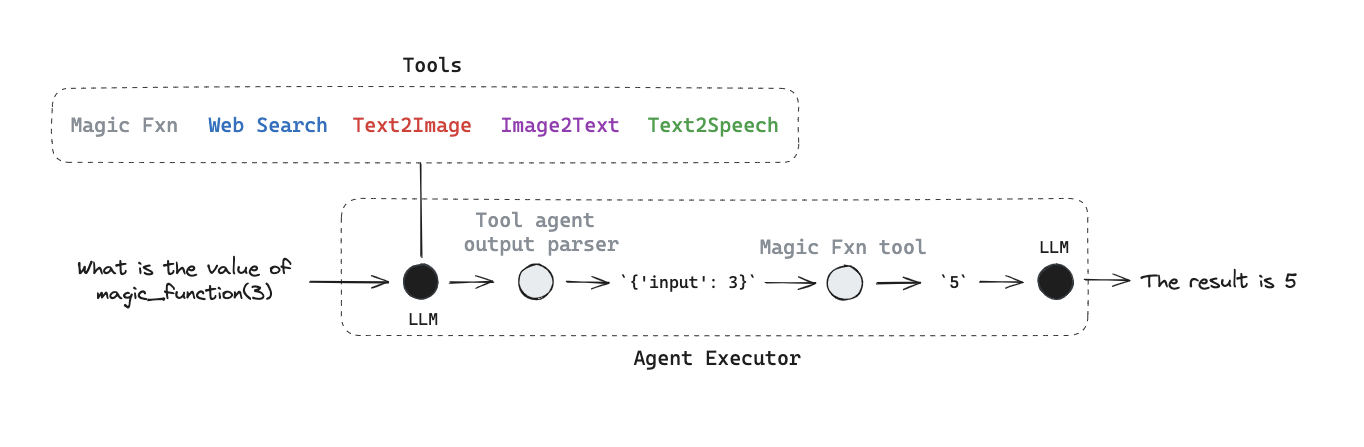

## Introduce the tools that we want our agent to use

### 1. Custom Function

This is a custom function that we want our agent to utilize.

In [1]:
def magic_function(input: int) -> int:
    """Applies a magic function to an input."""
    return input + 2

magic_function(3)

5

In [ ]:
from langchain.agents import tool

@tool
def magic_function(input: int) -> int:
    """Applies a magic function to an input."""
    return input + 2

### 2. Web Search

We'll use [Tavily](https://tavily.com/#api) for web search.

In [ ]:
# Ensure API key is set
import os
from getpass import getpass
TAVILY_API_KEY = getpass()
os.environ["TAVILY_API_KEY"] = TAVILY_API_KEY

In [4]:
from langchain_community.tools.tavily_search import TavilySearchResults
web_search_tool = TavilySearchResults()

### 3. Text-2-Image

We'll use [Replicate](https://replicate.com/), which offers free to try API key and hosts an [open DALL-E model](https://replicate.com/lucataco/open-dalle-v1.1/versions/1c7d4c8dec39c7306df7794b28419078cb9d18b9213ab1c21fdc46a1deca0144).

Test the code (this may take 1-2 minutes to run):

In [ ]:
# Ensure API key is set
REPLICATE_API_TOKEN = getpass()
os.environ["REPLICATE_API_TOKEN"] = REPLICATE_API_TOKEN

['https://replicate.delivery/pbxt/zdOZ0CkeysXSdy3fbtMioeAIEp7sYfDGsq0echfIHMXqTGwsE/out-0.png']


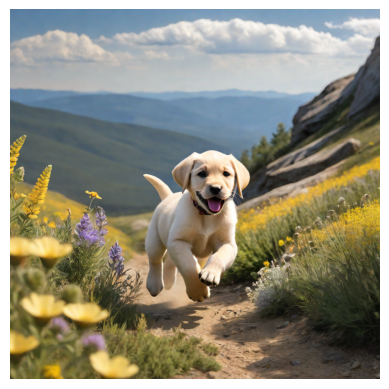

In [6]:
import replicate
import requests
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt

def display_image(image_url):
    """Display generated image"""
    response = requests.get(image_url)
    img = Image.open(BytesIO(response.content))  
    plt.imshow(img)
    plt.axis('off')
    plt.show()

def text2image(text: str) -> str:
    """generate an image based on a text."""
    output = replicate.run(
        "lucataco/open-dalle-v1.1:1c7d4c8dec39c7306df7794b28419078cb9d18b9213ab1c21fdc46a1deca0144",
        input={
            "width": 1024,
            "height": 1024,
            "prompt": text, #"a yellow lab puppy running free with wild flowers in the mountain behind",
            "scheduler": "KarrasDPM",
            "num_outputs": 1,
            "guidance_scale": 7.5,
            "apply_watermark": True,
            "negative_prompt": "worst quality, low quality",
            "prompt_strength": 0.8,
            "num_inference_steps": 60
        }
    )
    print(output)
    return output[0]

output = text2image("a yellow lab puppy running free with wild flowers in the mountain behind")
display_image(output)

Wrap the code above as a custom tool:

In [7]:
from langchain.agents import tool

@tool
def text2image(text: str) -> int:
    """generate an image based on a text."""    
    output = replicate.run(
        "lucataco/open-dalle-v1.1:1c7d4c8dec39c7306df7794b28419078cb9d18b9213ab1c21fdc46a1deca0144",
        input={
            "width": 1024,
            "height": 1024,
            "prompt": text, #"a yellow lab puppy running free with wild flowers in the mountain behind",
            "scheduler": "KarrasDPM",
            "num_outputs": 1,
            "guidance_scale": 7.5,
            "apply_watermark": True,
            "negative_prompt": "worst quality, low quality",
            "prompt_strength": 0.8,
            "num_inference_steps": 60
        }
    )
    print(output)
    return output[0]

### 4. Image-2-Text

We'll use Replicate, which hosts [llava-13b](https://replicate.com/yorickvp/llava-13b).

Test the code before converting it to a tool:

In [8]:
def image2text(image_url: str, prompt: str) -> int:
    """generate a text on image_url based on prompt."""
    input = {
        "image": image_url,
        "prompt": prompt
    }

    output = replicate.run(
        "yorickvp/llava-13b:b5f6212d032508382d61ff00469ddda3e32fd8a0e75dc39d8a4191bb742157fb",
        input=input
    )

    return "".join(output)

text = image2text(output, "tell me a bedtime story about the image")
text

'Once upon a time, in a beautiful mountain valley, there was a small, happy puppy named Max. Max loved to explore the outdoors and play in the wildflowers that grew on the mountainside. One day, Max decided to take a leap of faith and jump off a cliff, soaring through the air with excitement. As he landed, he found himself in a field of flowers, surrounded by the vibrant colors of yellow, purple, and white. Max was so delighted by his adventure that he started panting with joy and playfully barked at the flowers, as if they were his new friends. From that day on, Max continued to explore the mountain valley, always finding new ways to enjoy the beauty of nature and the thrill of adventure.'

Wrap the code above as another custom tool:

In [9]:
from langchain.agents import tool

@tool
def image2text(image_url: str, prompt: str) -> int:
    """generate a text on image_url based on prompt."""    
    input = {
        "image": image_url,
        "prompt": prompt
    }

    output = replicate.run(
        "yorickvp/llava-13b:b5f6212d032508382d61ff00469ddda3e32fd8a0e75dc39d8a4191bb742157fb",
        input=input
    )

    return "".join(output)

### 5. Text-2-Speech

We'll use Replicate, which hosts [text-2-speech](https://replicate.com/cjwbw/seamless_communication).

Test the code before creating yet another custom tool (this may take a couple of minutes to run):

In [10]:
from IPython.display import Audio

def play_audio(output_url):
    return Audio(url=output_url, autoplay=False)

def text2speech(text: str) -> int:
    """convert a text to a speech."""
    output = replicate.run(
        "cjwbw/seamless_communication:668a4fec05a887143e5fe8d45df25ec4c794dd43169b9a11562309b2d45873b0",
        input={
            "task_name": "T2ST (Text to Speech translation)",
            "input_text": text,
            "input_text_language": "English",
            "max_input_audio_length": 60,
            "target_language_text_only": "English",
            "target_language_with_speech": "English"
        }
    )
    return output['audio_output']

output_url = text2speech(text)
play_audio(output_url)

Wrap the code above to a new custom tool:

In [11]:
from langchain.agents import tool

@tool
def text2speech(text: str) -> int:
    """convert a text to a speech."""    
    output = replicate.run(
        "cjwbw/seamless_communication:668a4fec05a887143e5fe8d45df25ec4c794dd43169b9a11562309b2d45873b0",
        input={
            "task_name": "T2ST (Text to Speech translation)",
            "input_text": text,
            "input_text_language": "English",
            "max_input_audio_length": 60,
            "target_language_text_only": "English",
            "target_language_with_speech": "English"
        }
    )
    return output['audio_output']

Collect all tools created to a list:

In [12]:
tools = [magic_function, web_search_tool, text2image, image2text, text2speech]

tools

[StructuredTool(name='magic_function', description='magic_function(input: int) -> int - Applies a magic function to an input.', args_schema=<class 'pydantic.v1.main.magic_functionSchema'>, func=<function magic_function at 0x105a6f9c0>),
 TavilySearchResults(),
 StructuredTool(name='text2image', description='text2image(text: str) -> int - generate an image based on a text.', args_schema=<class 'pydantic.v1.main.text2imageSchema'>, func=<function text2image at 0x10f1d6de0>),
 StructuredTool(name='image2text', description='image2text(image_url: str, prompt: str) -> int - generate a text on image_url based on prompt.', args_schema=<class 'pydantic.v1.main.image2textSchema'>, func=<function image2text at 0x10f1d7ba0>),
 StructuredTool(name='text2speech', description='text2speech(text: str) -> int - convert a text to a speech.', args_schema=<class 'pydantic.v1.main.text2speechSchema'>, func=<function text2speech at 0x10f1ab4c0>)]

## LLM

Here, we need a Llama 3 model that supports tool use.

This can be accomplished via prompt engineering (e.g., see [here](https://replicate.com/hamelsmu/llama-3-70b-instruct-awq-with-tools)) or fine-tuning (e.g., see [here](https://huggingface.co/mzbac/llama-3-8B-Instruct-function-calling) and [here](https://huggingface.co/mzbac/llama-3-8B-Instruct-function-calling)).

We can review LangChain LLM integrations that support tool calling [here](https://python.langchain.com/docs/integrations/chat/) and Groq is included.

[Here](https://github.com/groq/groq-api-cookbook/blob/main/llama3-stock-market-function-calling/llama3-stock-market-function-calling.ipynb) is a notebook by Groq on function calling with Llama 3 and LangChain.

In [13]:
GROQ_API_KEY = getpass()

os.environ["GROQ_API_KEY"] = GROQ_API_KEY

 ········


In [14]:
from langchain_groq import ChatGroq
llm = ChatGroq(temperature=0, model="llama3-70b-8192")

## Agent

We use LangChain [tool calling agent](https://python.langchain.com/docs/modules/agents/agent_types/tool_calling/). 

In [15]:
# Prompt 
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
prompt = ChatPromptTemplate.from_messages(
    [
        ("system", "You are a helpful assistant"),
        ("human", "{input}"),
        MessagesPlaceholder("agent_scratchpad"),
    ]
)
prompt.pretty_print()

================================ System Message ================================

You are a helpful assistant

================================ Human Message =================================

{input}

============================= Messages Placeholder =============================

{agent_scratchpad}


In [16]:
# create an agent using the llm, tools and prompt created above
from langchain.agents import AgentExecutor, create_tool_calling_agent, tool
agent = create_tool_calling_agent(llm, tools, prompt)
agent_executor = AgentExecutor(agent=agent, tools=tools, return_intermediate_steps=True)

In [17]:
# this will invoke the magic_function tool
agent_executor.invoke({"input": "what is the value of magic_function(3)?"})

{'input': 'what is the value of magic_function(3)?',
 'output': 'The result of `magic_function(3)` is indeed 5.',
 'intermediate_steps': [(ToolAgentAction(tool='magic_function', tool_input={'input': 3}, log="\nInvoking: `magic_function` with `{'input': 3}`\n\n\n", message_log=[AIMessageChunk(content='', additional_kwargs={'tool_calls': [{'id': 'call_s7m7', 'function': {'arguments': '{"input":3}', 'name': 'magic_function'}, 'type': 'function'}]}, response_metadata={'finish_reason': 'tool_calls', 'logprobs': None}, id='run-c7d9aa30-c924-4f98-9ee7-811161a6ee1a', tool_calls=[{'name': 'magic_function', 'args': {'input': 3}, 'id': 'call_s7m7'}], tool_call_chunks=[{'name': 'magic_function', 'args': '{"input":3}', 'id': 'call_s7m7', 'index': None}])], tool_call_id='call_s7m7'),
   5)]}

Note that the `ToolAgentAction` in the returned `intermediate_steps` shows the tool called with input.

In [18]:
# this will invoke the tavily_search_results_json tool
agent_executor.invoke({"input": "whats the weather in sf?"})

{'input': 'whats the weather in sf?',
 'output': 'According to the tool call result, the current weather in San Francisco is sunny with a temperature of 64.9°F (18.3°C) and a humidity of 68%. The wind is blowing at 3.8 mph (6.1 kph) from the ENE direction.',
 'intermediate_steps': [(ToolAgentAction(tool='tavily_search_results_json', tool_input={'query': 'weather in san francisco'}, log="\nInvoking: `tavily_search_results_json` with `{'query': 'weather in san francisco'}`\n\n\n", message_log=[AIMessageChunk(content='', additional_kwargs={'tool_calls': [{'id': 'call_mzrb', 'function': {'arguments': '{"query":"weather in san francisco"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'finish_reason': 'tool_calls', 'logprobs': None}, id='run-709eea16-89af-4f04-80b7-14bbe331d3f6', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'weather in san francisco'}, 'id': 'call_mzrb'}], tool_call_chunks=[{'name': 'tavily_search_results_json', 'a

In [19]:
# this will invoke the text2image tool
output = agent_executor.invoke({"input": "generate an image based on this text: a yellow lab puppy running free with wild flowers in the mountain behind"})

['https://replicate.delivery/pbxt/En1lI29WUnpdANbpMKk2abYKxIvzK7WN7YTl4115S1hKHwsE/out-0.png']


In [21]:
output, output['intermediate_steps'][0][-1]

({'input': 'generate an image based on this text: a yellow lab puppy running free with wild flowers in the mountain behind',
  'output': 'Here is the result of the tool call:\n\nThe generated image is available at the provided URL: https://replicate.delivery/pbxt/En1lI29WUnpdANbpMKk2abYKxIvzK7WN7YTl4115S1hKHwsE/out-0.png',
  'intermediate_steps': [(ToolAgentAction(tool='text2image', tool_input={'text': 'a yellow lab puppy running free with wild flowers in the mountain behind'}, log="\nInvoking: `text2image` with `{'text': 'a yellow lab puppy running free with wild flowers in the mountain behind'}`\n\n\n", message_log=[AIMessageChunk(content='', additional_kwargs={'tool_calls': [{'id': 'call_6hjz', 'function': {'arguments': '{"text":"a yellow lab puppy running free with wild flowers in the mountain behind"}', 'name': 'text2image'}, 'type': 'function'}]}, response_metadata={'finish_reason': 'tool_calls', 'logprobs': None}, id='run-4b677104-9fa9-4e1b-8fed-2b898f7860eb', tool_calls=[{'name

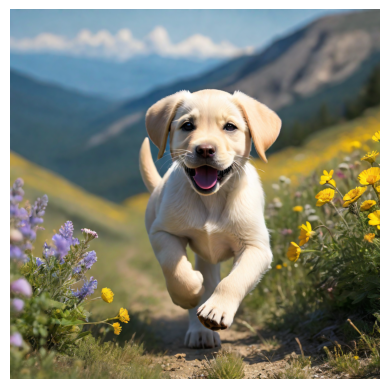

In [22]:
image_url = output['intermediate_steps'][0][-1]
display_image(image_url)

In [23]:
# this will invoke the image2text tool
output = agent_executor.invoke({"input": f"convert this image url to a bedtime story: {image_url}"})

In [24]:
output, output['intermediate_steps'][0][-1]

({'input': 'convert this image url to a bedtime story: https://replicate.delivery/pbxt/En1lI29WUnpdANbpMKk2abYKxIvzK7WN7YTl4115S1hKHwsE/out-0.png',
  'output': "What a lovely bedtime story! It sounds like Max had a wonderful adventure in the mountain valley, chasing butterflies and exploring the beautiful scenery. I'm glad he got to rest and appreciate the beauty around him. Would you like me to generate another story or assist you with something else?",
  'intermediate_steps': [(ToolAgentAction(tool='image2text', tool_input={'image_url': 'https://replicate.delivery/pbxt/En1lI29WUnpdANbpMKk2abYKxIvzK7WN7YTl4115S1hKHwsE/out-0.png', 'prompt': 'bedtime story'}, log="\nInvoking: `image2text` with `{'image_url': 'https://replicate.delivery/pbxt/En1lI29WUnpdANbpMKk2abYKxIvzK7WN7YTl4115S1hKHwsE/out-0.png', 'prompt': 'bedtime story'}`\n\n\n", message_log=[AIMessageChunk(content='', additional_kwargs={'tool_calls': [{'id': 'call_pc72', 'function': {'arguments': '{"image_url":"https://replicate.

In [25]:
# this will invoke the text2speech tool
story = output['intermediate_steps'][0][-1]
output = agent_executor.invoke({"input": f"convert the text to speech: {story}"})

In [26]:
output, output['intermediate_steps'][0][-1]

({'input': 'convert the text to speech: Once upon a time, in a beautiful mountain valley, there was a small white dog named Max. Max loved to explore the outdoors and was always eager to find new adventures. One day, he decided to take a walk along a trail that led to a stunning view of the mountains. As he ran along the trail, he came across a field filled with colorful flowers, including yellow ones. Max was so excited to see the flowers that he started running towards them, with his tongue hanging out, and his ears flapping in the wind.\n\nAs he ran, he noticed a group of butterflies flying around the flowers, adding to the beauty of the scene. Max was so captivated by the butterflies that he stopped running and started chasing them, trying to catch them in his mouth. The butterflies were playful and kept flying away, leading Max on a fun and exciting chase.\n\nAfter a while, Max realized that he was getting tired, so he decided to take a break and rest on the grass. As he lay down,

In [27]:
Audio(url=output['intermediate_steps'][0][-1], autoplay=False)

We can see that the agent correctly decides which tool to call for different query using AgentExecutor. 

In the next [notebook](langgraph-tool-calling-agent.ipynb), we will show an alternative way to implement this agent using LangGraph.